<a href="https://colab.research.google.com/github/szandian/Computer_Vision/blob/main/HW2_szandian_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# ---------------------------
# 1. DATA PREPARATION
# ---------------------------

In [ ]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.cifar10.load_data()

# Use only the training set (which has 5000 images per class) to create the mini dataset.
# For each of the 10 classes, take the first 150 images.
num_per_class = 150
x_mini_list, y_mini_list = [], []
y_train_full = y_train_full.flatten()
for c in range(10):
    idx = np.where(y_train_full == c)[0][:num_per_class]
    x_mini_list.append(x_train_full[idx])
    y_mini_list.append(y_train_full[idx])

x_mini = np.concatenate(x_mini_list, axis=0)
y_mini = np.concatenate(y_mini_list, axis=0)

# Shuffle the mini dataset
indices = np.arange(x_mini.shape[0])
np.random.shuffle(indices)
x_mini = x_mini[indices]
y_mini = y_mini[indices]

# Normalize images and one-hot encode labels
x_mini = x_mini.astype('float32') / 255.0
y_mini_cat = to_categorical(y_mini, num_classes=10)

# For stratified splitting we need 1D labels.
# Split the mini dataset into train (60%), validation (20%) and test (20%) with equal class distribution.
x_train, x_temp, y_train_cat, y_temp_cat, y_train, y_temp = train_test_split(
    x_mini, y_mini_cat, y_mini, train_size=0.6, stratify=y_mini, random_state=42)

# Split the remaining 40% equally into validation and test sets.
x_val, x_test, y_val_cat, y_test_cat, y_val, y_test = train_test_split(
    x_temp, y_temp_cat, y_temp, train_size=0.5, stratify=y_temp, random_state=42)

print("Train set:", x_train.shape, "Val set:", x_val.shape, "Test set:", x_test.shape)




Train set: (900, 32, 32, 3) Val set: (300, 32, 32, 3) Test set: (300, 32, 32, 3)


# ---------------------------
# 2. CUSTOM CALLBACK FOR TEST LOSS
# ---------------------------

In [ ]:

class TestLossCallback(Callback):
    """Callback to record test loss at the end of each epoch."""
    def __init__(self, test_data):
        super(TestLossCallback, self).__init__()
        self.test_data = test_data
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        x_test, y_test = self.test_data
        loss = self.model.evaluate(x_test, y_test, verbose=0)
        # If evaluate returns a list (loss, metrics...), take the loss
        if isinstance(loss, list):
            loss = loss[0]
        self.test_losses.append(loss)



# ---------------------------
# 3. HELPER FUNCTION: RESIZE IMAGES
# ---------------------------

In [ ]:

def resize_images(x, size=(224, 224)):
    # Resize a batch of images to the given size
    x_resized = np.array([tf.image.resize(image, size).numpy() for image in x])
    return x_resized



# ---------------------------
# 4. MODEL DEFINITIONS
# ---------------------------


In [ ]:
# Q1 – AlexNet architecture (a variant adapted for CIFAR-10 32x32 images)
def build_alexnet(lr=0.001):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=3, strides=1, activation='relu',
                     input_shape=(32,32,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Conv2D(384, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(384, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Q2 – VGG16 model with an option to add a dropout layer between convolutional layers.
def build_vgg16(lr=0.001, dropout=False):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    if dropout:
        x = Dropout(0.5)(x)  # Dropout added before flattening
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Q3 – RESNET50 model
def build_resnet50(lr=0.001):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Q4 – DenseNet121 model
def build_densenet121(lr=0.001):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Q5 – Custom CNN: FunkyNet (designed to be different from the above architectures)
def build_funkynet(lr=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# ---------------------------
# 5. HELPER FUNCTION: PLOT LOSSES
# ---------------------------
def plot_losses(history, test_losses, title):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



# ---------------------------
# 6. EXPERIMENTS
# ---------------------------

Running Q1: AlexNet experiments...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,927,754 (140.87 MB)

 Trainable params: 36,926,538 (140.86 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.1407 - loss: 10.1556 - val_accuracy: 0.1067 - val_loss: 2.3232
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2179 - loss: 2.3091 - val_accuracy: 0.1000 - val_loss: 2.6887
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2422 - loss: 2.1212 - val_accuracy: 0.1000 - val_loss: 3.4734
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2979 - loss: 1.9775 - val_accuracy: 0.1000 - val_loss: 2.7368
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2755 - loss: 2.0413 - val_accuracy: 0.1000 - val_loss: 3.3636
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3066 - loss: 1.9423 - val_accuracy: 0.0933 - val_loss: 3.4209
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2647 - loss: 1.8892 - val_accuracy: 0.1400 - val_loss: 2.8319
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3141 - loss: 1.8932 - val_accuracy: 0.1100 

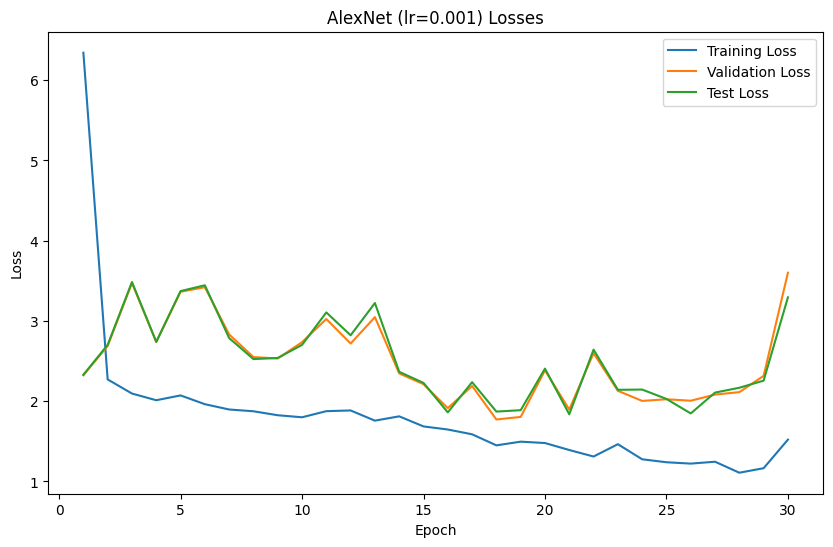

In [ ]:

# Q1: AlexNet Experiments
# ----------------------------------
print("Running Q1: AlexNet experiments...")

# Q1.1 – Train AlexNet with default learning rate (lr=0.001)
alexnet_default = build_alexnet(lr=0.001)
alexnet_default.summary()
test_callback_alex_default = TestLossCallback((x_test, y_test_cat))
history_alex_default = alexnet_default.fit(x_train, y_train_cat,
                                           epochs=30, validation_data=(x_val, y_val_cat),
                                           callbacks=[test_callback_alex_default], verbose=1)
plot_losses(history_alex_default, test_callback_alex_default.test_losses,
            "AlexNet (lr=0.001) Losses")



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,927,754 (140.87 MB)

 Trainable params: 36,926,538 (140.86 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.1040 - loss: 189.0761 - val_accuracy: 0.0533 - val_loss: 35.5604
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0743 - loss: 2.4383 - val_accuracy: 0.1033 - val_loss: 2.3654
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0984 - loss: 2.3138 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1114 - loss: 2.3136 - val_accuracy: 0.1033 - val_loss: 2.3034
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0918 - loss: 2.3100 - val_accuracy: 0.1000 - val_loss: 2.3036
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1124 - loss: 2.3562 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1064 - loss: 2.3061 - val_accuracy: 0.1000 - val_loss: 2.3040
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0773 - loss: 2.3098 - val_accuracy: 0.100

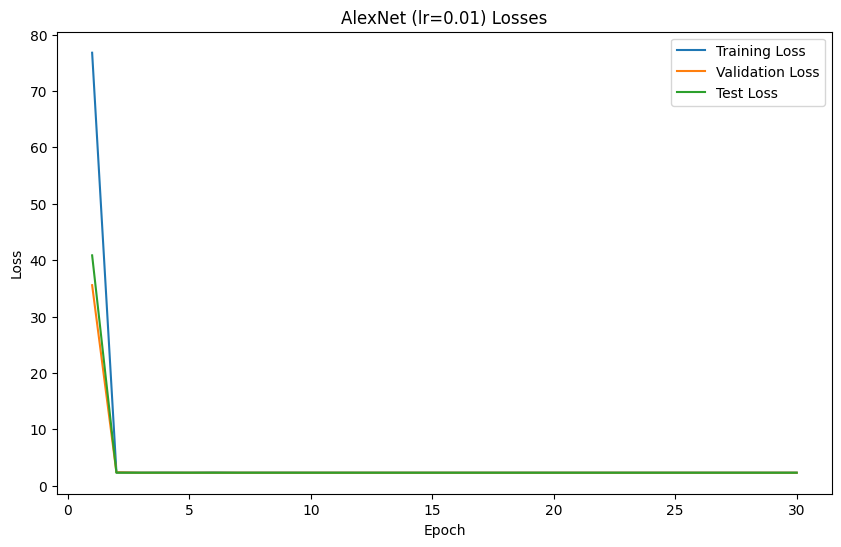

In [ ]:
# Q1.2 – Train AlexNet with a changed learning rate (here, increased to 0.01)
alexnet_lr_changed = build_alexnet(lr=0.01)
alexnet_lr_changed.summary()
test_callback_alex_lr = TestLossCallback((x_test, y_test_cat))
history_alex_lr = alexnet_lr_changed.fit(x_train, y_train_cat,
                                         epochs=30, validation_data=(x_val, y_val_cat),
                                         callbacks=[test_callback_alex_lr], verbose=1)
plot_losses(history_alex_lr, test_callback_alex_lr.test_losses,
            "AlexNet (lr=0.01) Losses")



In [ ]:
# Q2: VGG16 Experiments
# ----------------------------------
print("Running Q2: VGG16 experiments...")
# For VGG16 (and later ResNet/DenseNet), we need to resize images to 224x224.
x_train_resized = resize_images(x_train, (224,224))
x_val_resized   = resize_images(x_val, (224,224))
x_test_resized  = resize_images(x_test, (224,224))



Running Q2: VGG16 experiments...


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.1511 - loss: 3.4181 - val_accuracy: 0.2733 - val_loss: 2.0267
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3921 - loss: 1.7729 - val_accuracy: 0.3833 - val_loss: 1.7642
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5363 - loss: 1.4173 - val_accuracy: 0.4167 - val_loss: 1.6305
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6565 - loss: 1.1461 - val_accuracy: 0.4367 - val_loss: 1.5662
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6166 - loss: 1.0934 - val_accuracy: 0.4567 - val_loss: 1.4760
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7299 - loss: 0.8312 - val_accuracy: 0.4867 - val_loss: 1.4229
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7437 - loss: 0.8126 - val_accuracy: 0.5900 - val_loss: 1.3034
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8474 - loss: 0.6320 - val_accuracy: 0.5267 -

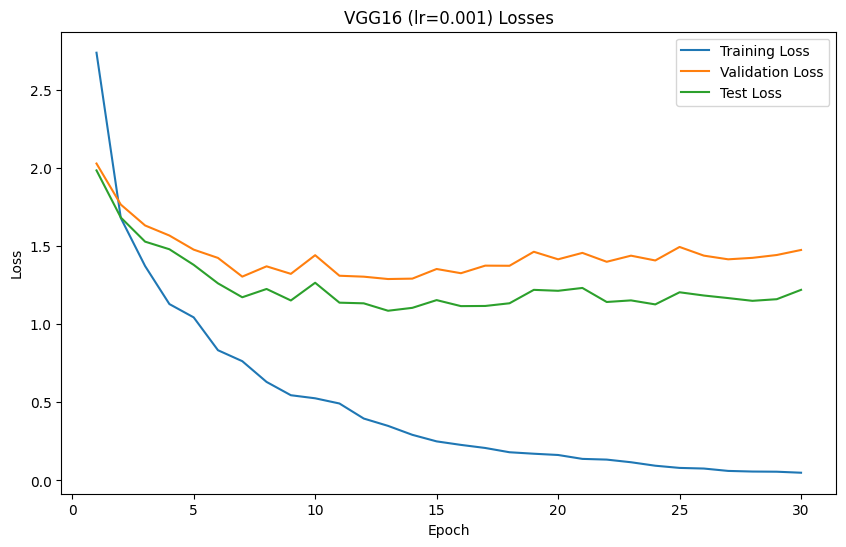

In [ ]:
# Q2.1 – Train VGG16 with default learning rate (lr=0.001) and no dropout added
vgg16_default = build_vgg16(lr=0.001, dropout=False)
vgg16_default.summary()
test_callback_vgg = TestLossCallback((x_test_resized, y_test_cat))
history_vgg16_default = vgg16_default.fit(x_train_resized, y_train_cat,
                                          epochs=30, validation_data=(x_val_resized, y_val_cat),
                                          callbacks=[test_callback_vgg], verbose=1)
plot_losses(history_vgg16_default, test_callback_vgg.test_losses,
            "VGG16 (lr=0.001) Losses")



Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.1065 - loss: 24.8517 - val_accuracy: 0.1800 - val_loss: 2.1888
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1836 - loss: 2.1565 - val_accuracy: 0.2000 - val_loss: 2.1845
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2476 - loss: 2.0818 - val_accuracy: 0.2300 - val_loss: 2.0515
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2539 - loss: 1.9185 - val_accuracy: 0.2567 - val_loss: 2.0548
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2832 - loss: 1.8579 - val_accuracy: 0.2500 - val_loss: 1.9557
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2669 - loss: 1.8103 - val_accuracy: 0.2833 - val_loss: 1.9977
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3163 - loss: 1.7470 - val_accuracy: 0.2600 - val_loss: 1.9083
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3209 - loss: 1.6809 - val_accuracy: 0.2700 -

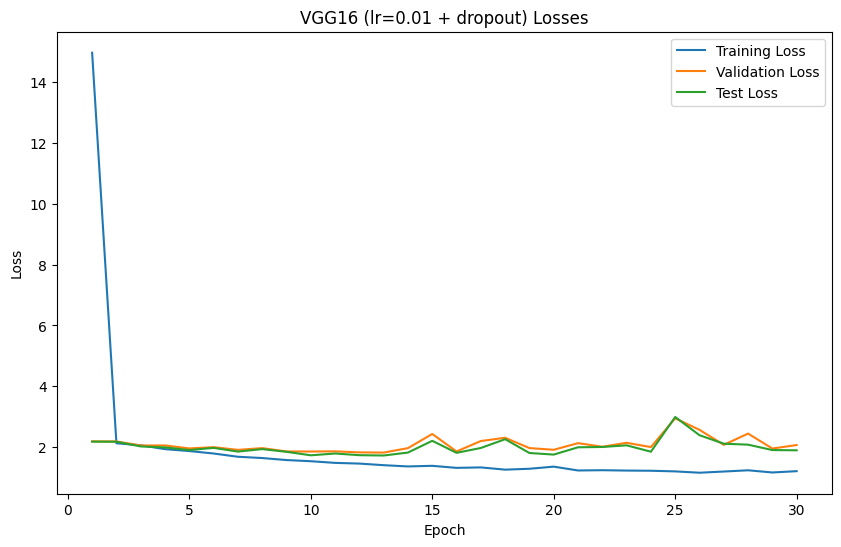

In [ ]:
# Q2.2 – Train VGG16 with increased learning rate (lr=0.01) and add a dropout layer
vgg16_dropout = build_vgg16(lr=0.01, dropout=True)
vgg16_dropout.summary()
test_callback_vgg_dropout = TestLossCallback((x_test_resized, y_test_cat))
history_vgg16_dropout = vgg16_dropout.fit(x_train_resized, y_train_cat,
                                          epochs=30, validation_data=(x_val_resized, y_val_cat),
                                          callbacks=[test_callback_vgg_dropout], verbose=1)
plot_losses(history_vgg16_dropout, test_callback_vgg_dropout.test_losses,
            "VGG16 (lr=0.01 + dropout) Losses")



Running Q3: ResNet50 experiment...


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 488ms/step - accuracy: 0.0813 - loss: 2.5253 - val_accuracy: 0.1000 - val_loss: 2.3861
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.0633 - loss: 2.3828 - val_accuracy: 0.1000 - val_loss: 2.3385
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1140 - loss: 2.3451 - val_accuracy: 0.1000 - val_loss: 2.3002
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0997 - loss: 2.3250 - val_accuracy: 0.1000 - val_loss: 2.3036
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1087 - loss: 2.3243 - val_accuracy: 0.1300 - val_loss: 2.3301
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1019 - loss: 2.3383 - val_accuracy: 0.1000 - val_loss: 2.2998
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1174 - loss: 2.3097 - val_accuracy: 0.1667 - val_loss: 2.2969
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1162 - loss: 2.3410 - val_accuracy: 0.1767 -

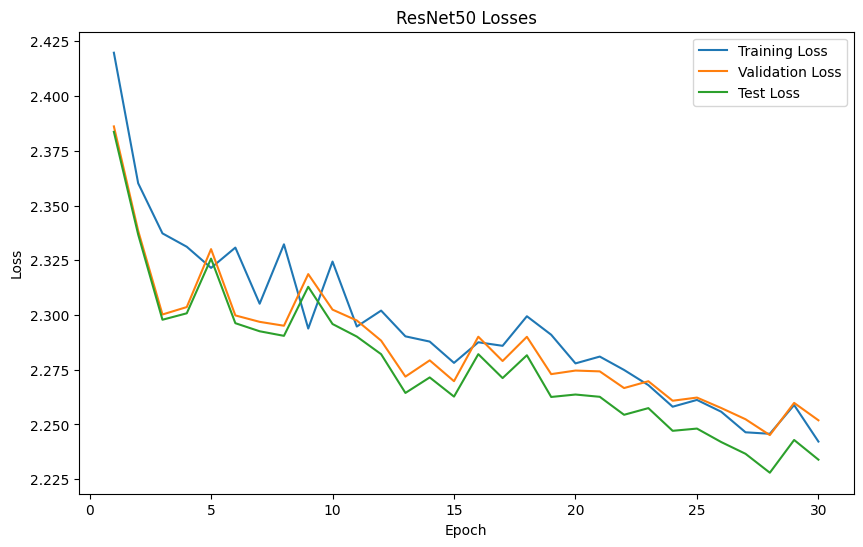

In [ ]:
# Q3: RESNET50 Experiment
# ----------------------------------
print("Running Q3: ResNet50 experiment...")
resnet50_model = build_resnet50(lr=0.001)
resnet50_model.summary()
test_callback_resnet = TestLossCallback((x_test_resized, y_test_cat))
history_resnet50 = resnet50_model.fit(x_train_resized, y_train_cat,
                                      epochs=30, validation_data=(x_val_resized, y_val_cat),
                                      callbacks=[test_callback_resnet], verbose=1)
plot_losses(history_resnet50, test_callback_resnet.test_losses,
            "ResNet50 Losses")



Running Q4: DenseNet121 experiment...


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,302,474 (27.86 MB)

 Trainable params: 264,970 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3221 - loss: 2.0913 - val_accuracy: 0.6100 - val_loss: 1.1592
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6957 - loss: 0.9327 - val_accuracy: 0.6400 - val_loss: 1.0290
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8160 - loss: 0.6564 - val_accuracy: 0.6200 - val_loss: 1.0279
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8353 - loss: 0.5533 - val_accuracy: 0.6700 - val_loss: 0.9379
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8789 - loss: 0.4569 - val_accuracy: 0.6867 - val_loss: 0.9251
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9052 - loss: 0.3650 - val_accuracy: 0.6733 - val_loss: 0.9055
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9255 - loss: 0.2912 - val_accuracy: 0.6800 - val_loss: 0.9294
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9364 - loss: 0.2813 - val_accuracy: 0.6833 - va

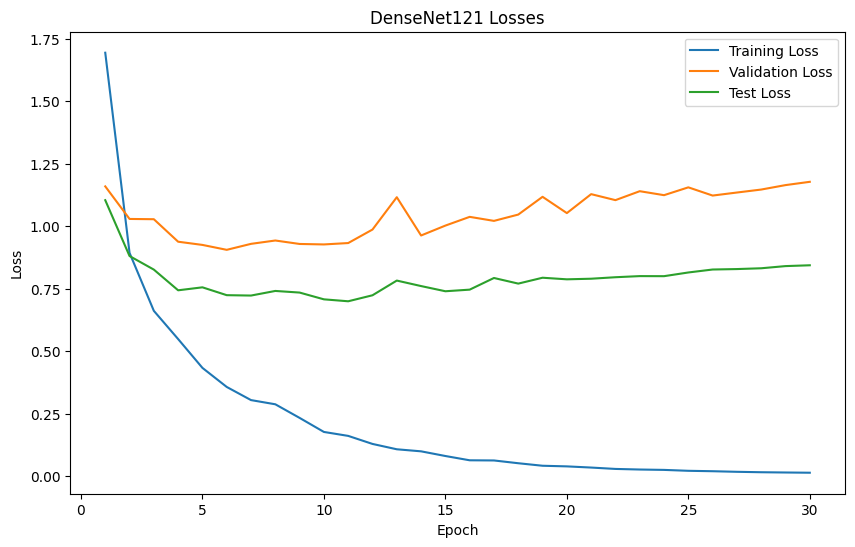

In [ ]:
# Q4: DenseNet121 Experiment
# ----------------------------------
print("Running Q4: DenseNet121 experiment...")
densenet121_model = build_densenet121(lr=0.001)
densenet121_model.summary()
test_callback_densenet = TestLossCallback((x_test_resized, y_test_cat))
history_densenet121 = densenet121_model.fit(x_train_resized, y_train_cat,
                                            epochs=30, validation_data=(x_val_resized, y_val_cat),
                                            callbacks=[test_callback_densenet], verbose=1)
plot_losses(history_densenet121, test_callback_densenet.test_losses,
            "DenseNet121 Losses")



Running Q5: FunkyNet experiment...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,143,242 (4.36 MB)

 Trainable params: 1,143,242 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.1132 - loss: 2.3287 - val_accuracy: 0.1033 - val_loss: 2.2703
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1549 - loss: 2.2524 - val_accuracy: 0.2067 - val_loss: 2.1477
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1960 - loss: 2.1741 - val_accuracy: 0.2467 - val_loss: 2.0550
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2135 - loss: 2.0342 - val_accuracy: 0.3000 - val_loss: 1.9239
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2679 - loss: 1.9485 - val_accuracy: 0.2900 - val_loss: 1.8669
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3480 - loss: 1.7631 - val_accuracy: 0.3333 - val_loss: 1.7783
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3178 - loss: 1.7847 - val_accuracy: 0.3967 - val_loss: 1.7175
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3767 - loss: 1.6610 - val_accuracy: 0.3700 - val_lo

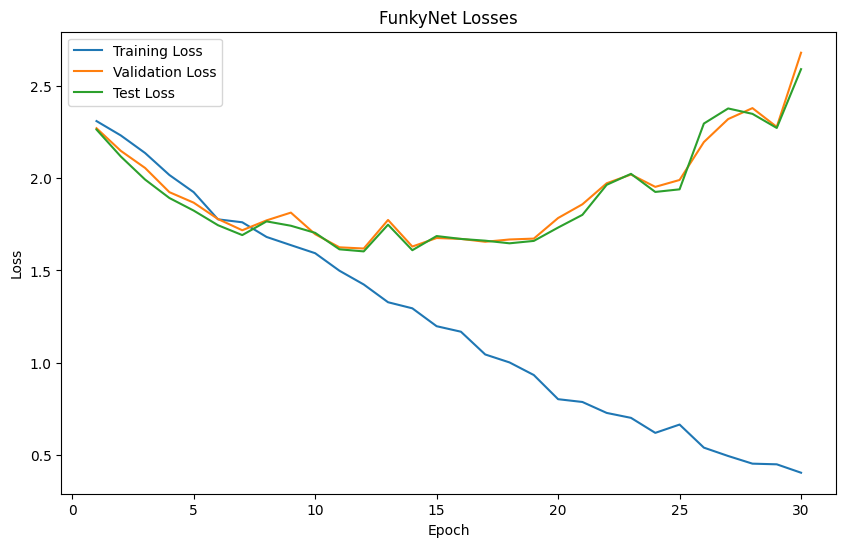

In [ ]:
# Q5: Custom CNN – FunkyNet Experiment
# ----------------------------------
print("Running Q5: FunkyNet experiment...")
funkynet = build_funkynet(lr=0.001)
funkynet.summary()
test_callback_funkynet = TestLossCallback((x_test, y_test_cat))
history_funkynet = funkynet.fit(x_train, y_train_cat,
                                epochs=30, validation_data=(x_val, y_val_cat),
                                callbacks=[test_callback_funkynet], verbose=1)
plot_losses(history_funkynet, test_callback_funkynet.test_losses,
            "FunkyNet Losses")
